In [7]:
import pandas as pd

estate = pd.read_csv(r"C:\Users\colka\OneDrive\Documents\WebStore\data\datasources\challenges\data\real_estate.csv")
print( estate.head())
estate.info()

   transaction_date  house_age  ...  longitude  price_per_unit
0          2012.917       32.0  ...  121.54024            37.9
1          2012.917       19.5  ...  121.53951            42.2
2          2013.583       13.3  ...  121.54391            47.3
3          2013.500       13.3  ...  121.54391            54.8
4          2012.833        5.0  ...  121.54245            43.1

[5 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   transaction_date          414 non-null    float64
 1   house_age                 414 non-null    float64
 2   transit_distance          414 non-null    float64
 3   local_convenience_stores  414 non-null    int64  
 4   latitude                  414 non-null    float64
 5   longitude                 414 non-null    float64
 6   price_per_unit            414 non-null    float64
d

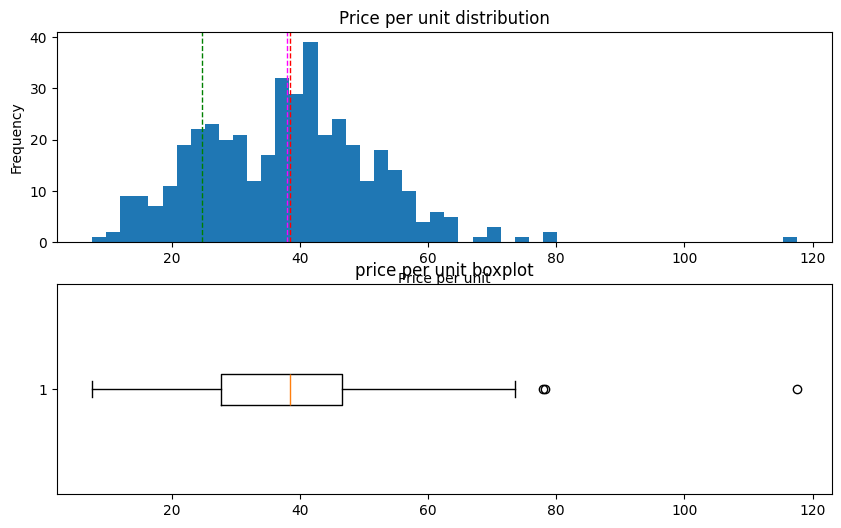

In [31]:
import matplotlib.pyplot as plt
import numpy as np

fig,ax = plt.subplots(2,1,figsize = (10,6))

ax[0].hist(estate['price_per_unit'],bins=50)
ax[0].set_title('Price per unit distribution')
ax[0].set_xlabel('Price per unit')
ax[0].set_ylabel('Frequency')

ax[0].axvline(estate['price_per_unit'].mean(), color='magenta', linestyle='dashed', linewidth=1)
ax[0].axvline(estate['price_per_unit'].median(), color='red', linestyle='dashed', linewidth=1)
ax[0].axvline(estate['price_per_unit'].mode()[0], color='green', linestyle='dashed', linewidth=1)

ax[1].boxplot(estate['price_per_unit'], vert=False)
ax[1].set_title('price per unit boxplot')

plt.show()


In [33]:
estate = estate[estate['price_per_unit'] < 70]

In [34]:
transactionMonth = pd.DataFrame(estate['transaction_date'])
transactionMonth['transaction_date'] = ((transactionMonth['transaction_date'] % 1) * 12).round().astype(int)
estate['TransactionMonth'] = transactionMonth
estate['local_convenience_stores'] = estate['local_convenience_stores'].clip(upper=5)
estate['amenitys'] = estate['local_convenience_stores'] + (1/(estate['transit_distance'] + 1))
print(estate.head(20))

    transaction_date  house_age  ...  amenitys  amenitysScore
0           2012.917       32.0  ...  5.011644       0.994174
1           2012.917       19.5  ...  5.003251       0.992509
2           2013.583       13.3  ...  5.001776       0.992216
3           2013.500       13.3  ...  5.001776       0.992216
4           2012.833        5.0  ...  5.002554       0.992371
5           2012.667        7.1  ...  3.000460       0.595192
6           2012.667       34.5  ...  5.001601       0.992182
7           2013.417       20.3  ...  5.003465       0.992551
8           2013.500       31.7  ...  1.000181       0.198374
9           2013.417       17.9  ...  3.000560       0.595212
10          2013.083       34.8  ...  1.002462       0.198827
11          2013.333        6.3  ...  5.010934       0.994033
12          2012.917       13.0  ...  5.002027       0.992266
13          2012.667       20.4  ...  4.000405       0.793563
14          2013.500       13.2  ...  4.000858       0.793653
15      

Coefficients: [-2.63700077e-01 -6.95615172e+02 -4.06331016e-03 -6.34344359e-02
  3.51588235e+03]
Mean Squared Error: 83.82299211680827
Root Mean Squared Error: 9.15548972566778
R2 score: 0.4913578030804232


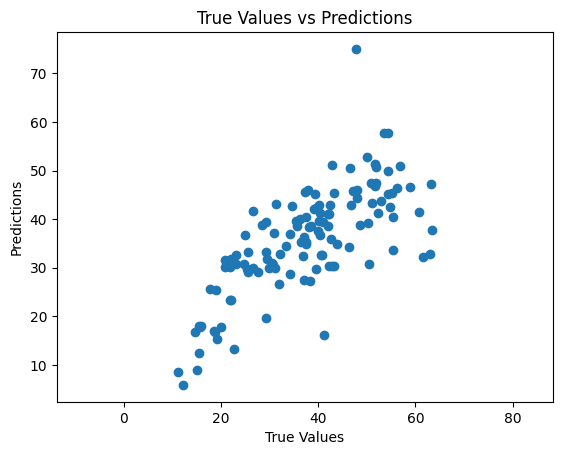

In [47]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

estate['amenitysScore'] = MinMaxScaler().fit_transform(estate[['amenitys']])

x,y = estate[['house_age', 'local_convenience_stores', 'transit_distance', 'TransactionMonth', 'amenitysScore']], estate['price_per_unit']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)
model = LinearRegression()
modelinfo = model.fit(x_train, y_train)
lprediction = model.predict(x_test)

mse = mean_squared_error(y_test,lprediction)
rmse = np.sqrt(mse)
r2Score = r2_score(y_test,lprediction)

plt.scatter(y_test,lprediction)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.title('True Values vs Predictions')

print(f'Coefficients: {modelinfo.coef_}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2 score: {r2Score}')


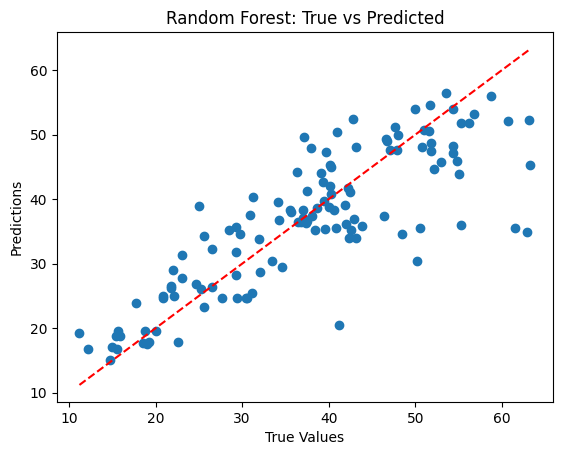

Random Forest Mean squared Error: 53.01371719599188
Random Forest Root Mean squared Error: 7.281051929219561
Random Forest R2 Score: 0.6783100566982099


In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np


num_scaler = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(transformers = [
    ('num', num_scaler, ['house_age', 'transit_distance', 'amenitysScore','local_convenience_stores','TransactionMonth'],)
])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators = 100, random_state = 42))
])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)


grid_search.fit(x_train, y_train)

rf_prediction = grid_search.predict(x_test)

rf_mse = mean_squared_error(y_test, rf_prediction)
rf_rmse = root_mean_squared_error(y_test, rf_prediction)
rf_r2_score = r2_score(y_test, rf_prediction)

plt.scatter(y_test, rf_prediction)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Random Forest: True vs Predicted')
plt.show()

print(f'Random Forest Mean squared Error: {rf_mse}')
print(f'Random Forest Root Mean squared Error: {rf_rmse}')
print(f'Random Forest R2 Score: {rf_r2_score}')
